In [14]:
!pip install -q spotipy transformers torch torchaudio librosa scikit-learn pandas numpy matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.7 MB/s eta 0:00:00


In [25]:
# Install required packages
!pip install -q scikit-learn pandas numpy

import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess data
def load_and_preprocess():
    url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv"
    df = pd.read_csv(url)

    # Standardize column names
    df.columns = df.columns.str.lower()

    # Handle missing artist/track names
    df = df.dropna(subset=['track_name', 'track_artist'])
    df = df[df['track_artist'] != '']

    # Define consistent feature set
    features = ['danceability', 'energy', 'valence', 'tempo',
               'loudness', 'acousticness', 'instrumentalness']

    # Fill missing feature values with median
    for feature in features:
        df[feature] = df[feature].fillna(df[feature].median())

    # Normalize features
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])

    # Classify moods
    conditions = [
        (df['valence'] > 0.7) & (df['energy'] > 0.7),
        (df['valence'] > 0.6) & (df['energy'] > 0.5),
        (df['energy'] > 0.7),
        (df['valence'] < 0.3) & (df['energy'] < 0.4),
        (df['acousticness'] > 0.6),
        (df['instrumentalness'] > 0.7)
    ]
    choices = ['ecstatic', 'happy', 'energetic', 'sad', 'calm', 'instrumental']
    df['mood'] = np.select(conditions, choices, default='neutral')

    return df, features

df, features = load_and_preprocess()

# Build recommender
recommender = NearestNeighbors(n_neighbors=50, metric='cosine')
recommender.fit(df[features])

# Recommendation function
def recommend_songs(mood, n=5):
    mood_tracks = df[df['mood'] == mood]
    if len(mood_tracks) == 0:
        return None

    # Get diverse recommendations
    seed_indices = np.random.choice(mood_tracks.index, size=min(10, len(mood_tracks)), replace=False)
    _, indices = recommender.kneighbors(df.loc[seed_indices, features])
    unique_indices = np.unique(indices)

    recs = df.loc[unique_indices]
    recs = recs[recs['mood'] == mood]
    return recs[['track_name', 'track_artist', 'mood']].sample(min(n, len(recs)))

# Mood detection
def detect_mood(text):
    mood_keywords = {
        'ecstatic': ['ecstatic', 'thrilled', 'overjoyed'],
        'happy': ['happy', 'joyful', 'cheerful'],
        'energetic': ['energetic', 'pumped', 'excited'],
        'sad': ['sad', 'depressed', 'melancholy'],
        'calm': ['calm', 'relaxed', 'peaceful'],
        'instrumental': ['instrumental', 'orchestral', 'classical']
    }

    text = text.lower()
    for mood, keywords in mood_keywords.items():
        if any(keyword in text for keyword in keywords):
            return mood
    return 'neutral'

# Main interface
def main():
    print("🎵 Fixed Mood Music Recommender 🎵")
    print("--------------------------------")
    print(f"Loaded {len(df)} tracks")
    print("Available moods:", df['mood'].unique())

    while True:
        user_input = input("\nHow are you feeling today? (or 'quit' to exit): ").strip()

        if user_input.lower() == 'quit':
            break

        if len(user_input.split()) < 3:
            print("Please enter at least 3 words for better recommendations.")
            continue

        try:
            mood = detect_mood(user_input)
            print(f"\nDetected Mood: {mood}")

            recs = recommend_songs(mood)
            if recs is not None and len(recs) > 0:
                print("\n🎶 Recommended Songs:")
                print(recs.to_string(index=False))
            else:
                print("\nNo matching songs found. Try a different mood description.")

        except Exception as e:
            print(f"\nError: {str(e)}")

if __name__ == "__main__":
    main()

🎵 Fixed Mood Music Recommender 🎵
--------------------------------
Loaded 32828 tracks
Available moods: ['energetic' 'happy' 'ecstatic' 'neutral' 'calm' 'sad' 'instrumental']

How are you feeling today? (or 'quit' to exit): happy
Please enter at least 3 words for better recommendations.

How are you feeling today? (or 'quit' to exit): happy calm energetic

Detected Mood: happy

🎶 Recommended Songs:
            track_name                track_artist  mood
           No Flockin'                 Kodak Black happy
           Pretty Girl                      Jon B. happy
Woah (feat. D3Mstreet)                  KRYPTO9095 happy
         Great Jehovah Soul (Mo Henderson's Group) happy
             Hollywood                         RAC happy

How are you feeling today? (or 'quit' to exit): sad cry worry

Detected Mood: sad

🎶 Recommended Songs:
 track_name  track_artist mood
Colourblind   Tones and I  sad
Perspective  Barnes Blvd.  sad
   Fast Car Tracy Chapman  sad
    caronte    Alba Reche  s

**Mood Distribution Pie Chart**

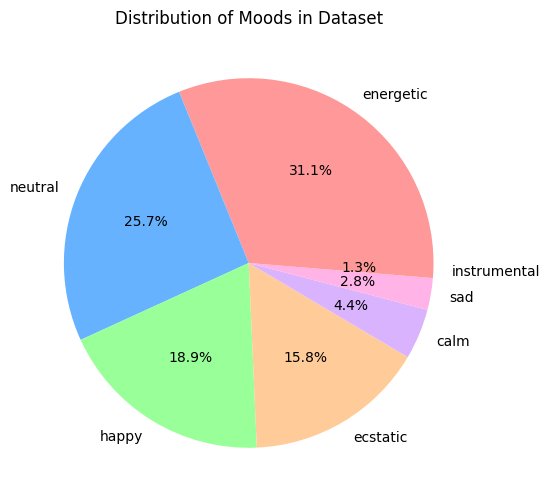

In [26]:
import matplotlib.pyplot as plt

# Mood distribution
mood_counts = df['mood'].value_counts()
plt.figure(figsize=(10,6))
plt.pie(mood_counts, labels=mood_counts.index, autopct='%1.1f%%',
        colors=['#FF9999','#66B2FF','#99FF99','#FFCC99','#DAB3FF','#FFB3E6'])
plt.title('Distribution of Moods in Dataset')
plt.show()

**Audio Features Radar Chart**

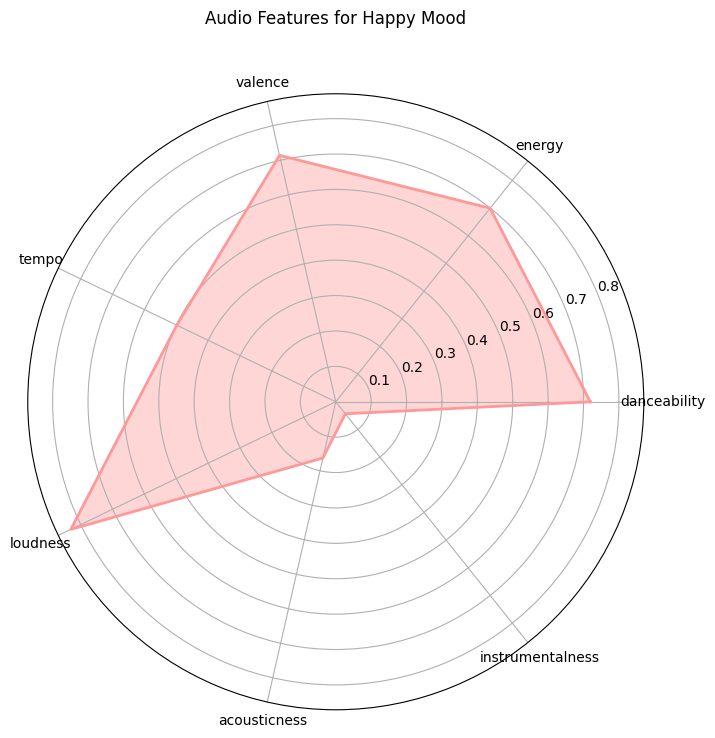

In [27]:
from math import pi

# Average features by mood
mood_avg = df.groupby('mood')[features].mean()

# Radar chart function
def make_radar_chart(mood):
    categories = features
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, polar=True)

    values = mood_avg.loc[mood].tolist()
    values += values[:1]

    ax.plot(angles, values, color='#FF9999', linewidth=2, linestyle='solid')
    ax.fill(angles, values, color='#FF9999', alpha=0.4)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_title(f'Audio Features for {mood.capitalize()} Mood', y=1.1)

    return fig

# Example usage
make_radar_chart('happy')
plt.show()

**Mood Transition Network Graph**

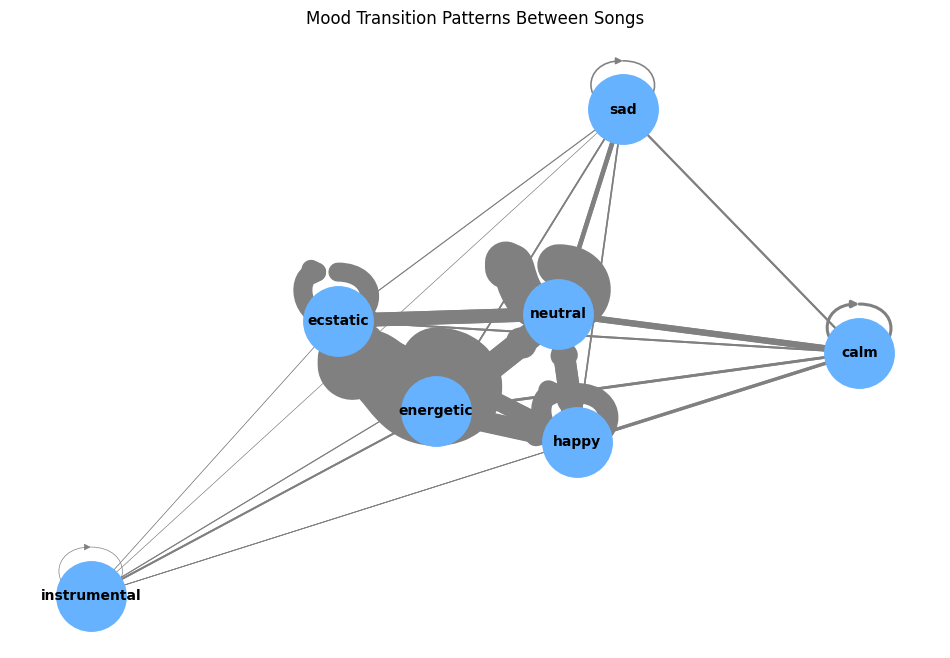

In [28]:
import networkx as nx
from itertools import combinations

# Create transition probabilities between moods
playlist_moods = df.sort_values('playlist_id').groupby('playlist_id')['mood'].agg(list)
transitions = pd.Series([list(zip(x, x[1:])) for x in playlist_moods]).explode().value_counts()

# Create graph
G = nx.DiGraph()
for (source, target), weight in transitions.items():
    G.add_edge(source, target, weight=weight)

# Draw graph
plt.figure(figsize=(12,8))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=2500, node_color='#66B2FF')
nx.draw_networkx_edges(G, pos, edge_color='gray', width=[d['weight']/100 for _,_,d in G.edges(data=True)])
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
plt.title('Mood Transition Patterns Between Songs')
plt.axis('off')
plt.show()

**Mood Over Time (Tempo vs Valence)**


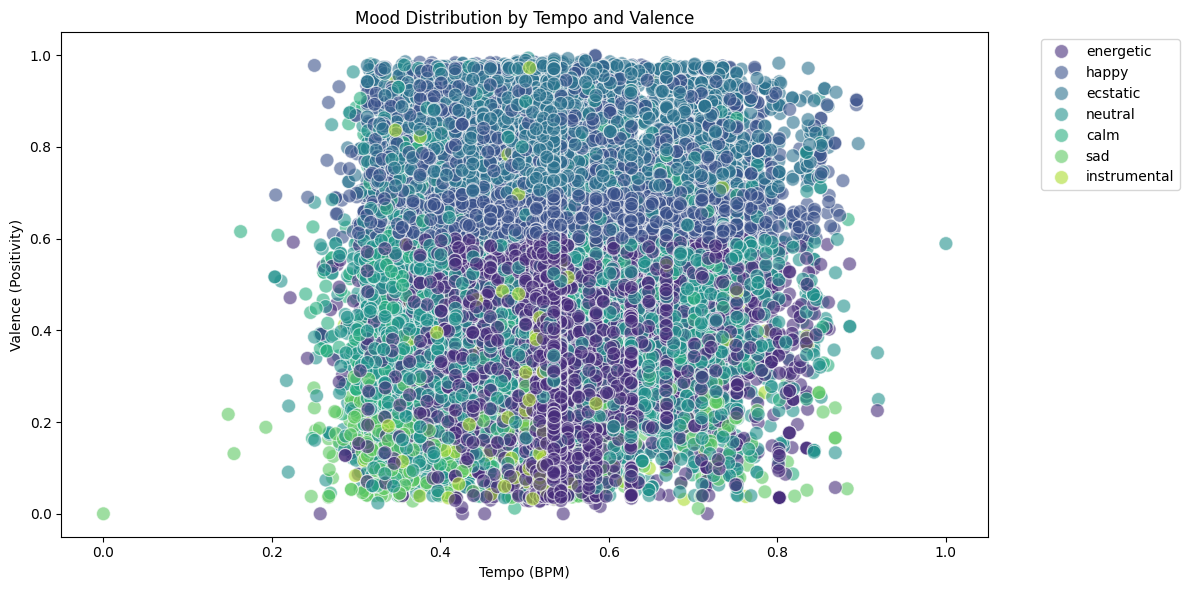

In [29]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df, x='tempo', y='valence', hue='mood',
                palette='viridis', alpha=0.6, s=100)
plt.title('Mood Distribution by Tempo and Valence')
plt.xlabel('Tempo (BPM)')
plt.ylabel('Valence (Positivity)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Interactive Mood Explorer**

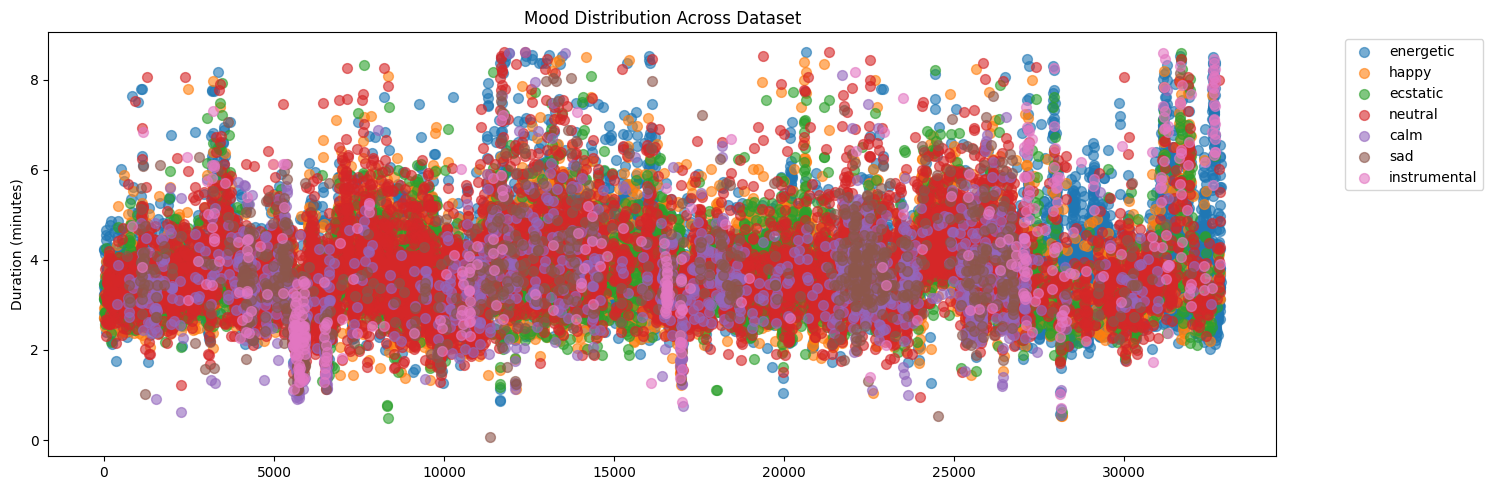

In [31]:
import matplotlib.dates as mdates

# Convert duration to datetime-like for visualization
df['duration_min'] = df['duration_ms'] / 60000
plt.figure(figsize=(15,5))

for mood in df['mood'].unique():
    subset = df[df['mood'] == mood]
    plt.scatter(subset.index, subset['duration_min'],
                label=mood, alpha=0.6, s=50)

plt.ylabel('Duration (minutes)')
plt.title('Mood Distribution Across Dataset')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()